# Setup and loading data

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

Note: After the following pip install, need to restart the kernel.

In [3]:
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

from collections import defaultdict
from collections import Counter

import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random

In [5]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV

import scikitplot as skplt

In [6]:
# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable

In [8]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [9]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [61]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [10]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

### Load data

In [11]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [12]:
# Load data
if IN_COLAB:
    file = open('drive/My Drive/Colab Data/nontext_train.pickle', 'rb')
else:
    file = open('../data/train_data/nontext_train.pickle', 'rb')

train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df.head()

(398, 8)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Hsales_diff_year
date,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-15.485275
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-9.537496
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-3.116275
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.774432
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.774432


### Balancing the classes

In [13]:
# Percentage before the balancing
n_hold = sum(1 for each in train_df['target'] if each == 0)
n_lower = sum(1 for each in train_df['target'] if each == -1)
n_raise = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)

print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


Here, take random sampling approach to balance the data. Though it loses some data, easy to process and less prone to the bias.<BER />

_Update: Decided not to do this as we do not have a lot of data. Consider different approach to tackle this imbalanced data issue. Thus, set keep_prob = 1 (keep everything). _

In [26]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 0)
N_examples = len(train_df)

# Keep probability (specify decimal value between 0 and 1)
#keep_prob = (N_examples - n_hold)/2/n_hold
keep_prob = 1

balanced = pd.concat([train_df.loc[train_df['target'] != 0], train_df.loc[train_df['target'] == 0].sample(frac=keep_prob, random_state=1)])
balanced.sort_index(ascending=True, inplace=True)

n_hold = sum(1 for each in balanced['target'] if each == 0)
n_lower = sum(1 for each in balanced['target'] if each == -1)
n_raise = sum(1 for each in balanced['target'] if each == 1)
N_examples = len(balanced['target'])
print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


In [27]:
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

In [28]:
Y_balanced = balanced['target'].map(convert_class)
X_balanced = balanced.drop(columns=['target'])


In [29]:
# Because the prediction should be on the latest and should not look back, use shuffle=False
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_balanced.values, Y_balanced.values, test_size=0.2, shuffle=False)

In [70]:
print("Training Data: Total {}, {}".format(len(Y_train), Counter(Y_train)))
print("Test Data: Total {}, {}".format(len(Y_test), Counter(Y_test)))

Training Data: Total 318, Counter({2: 203, 1: 63, 3: 52})
Test Data: Total 80, Counter({2: 61, 3: 10, 1: 9})


# Modeling and Training

## A. Non-text data

Imbalanced data

In [71]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [74]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))


cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

In [75]:
cv_res.sort_values(by='CVAccMeans', ascending=False)

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
0,SVC,0.638365,0.004447,0.259754,0.001107
11,Perceptron,0.556604,0.120322,0.282041,0.010587
9,LinearDiscriminantAnalysis,0.547170,0.040759,0.427940,0.011265
6,MultipleLayerPerceptron,0.537736,0.083318,0.294662,0.034000
8,LogisticRegression,0.518868,0.078175,0.346438,0.031601
3,RandomForest,0.512579,0.069468,0.411223,0.079456
7,KNeighboors,0.490566,0.069325,0.382150,0.060057
10,GaussianNB,0.490566,0.113469,0.470957,0.096449
4,ExtraTrees,0.484277,0.059831,0.368908,0.043343
13,SGD,0.455975,0.182661,0.254886,0.087015


Text(0.5, 1.0, 'Cross validation scores')

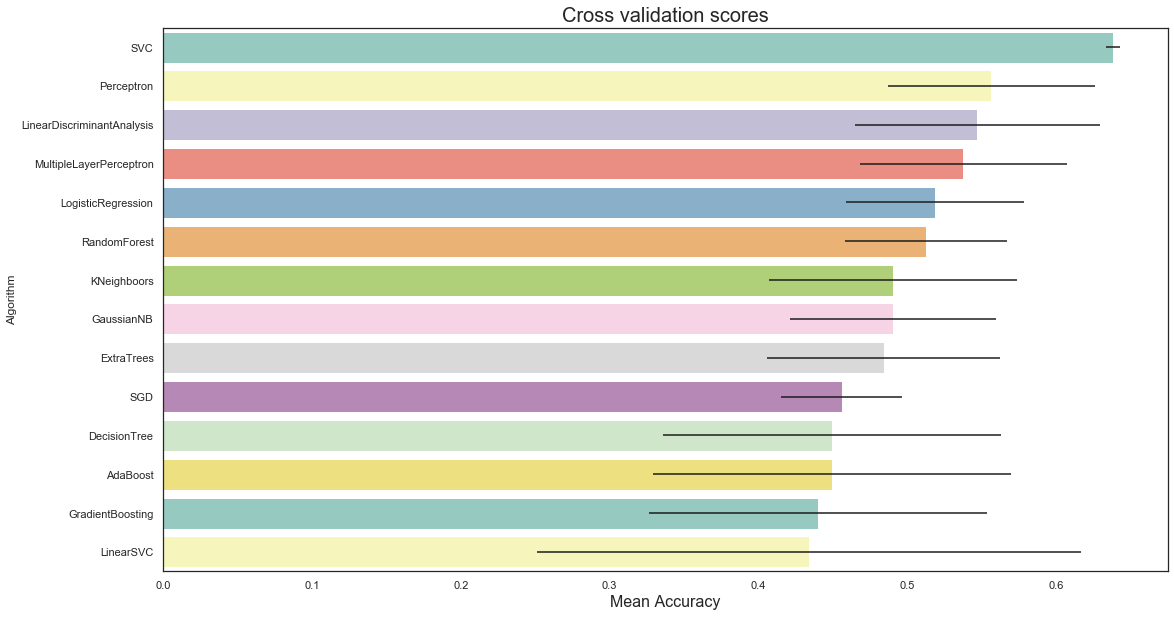

In [76]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation scores", size=20)


Text(0.5, 1.0, 'Cross validation scores')

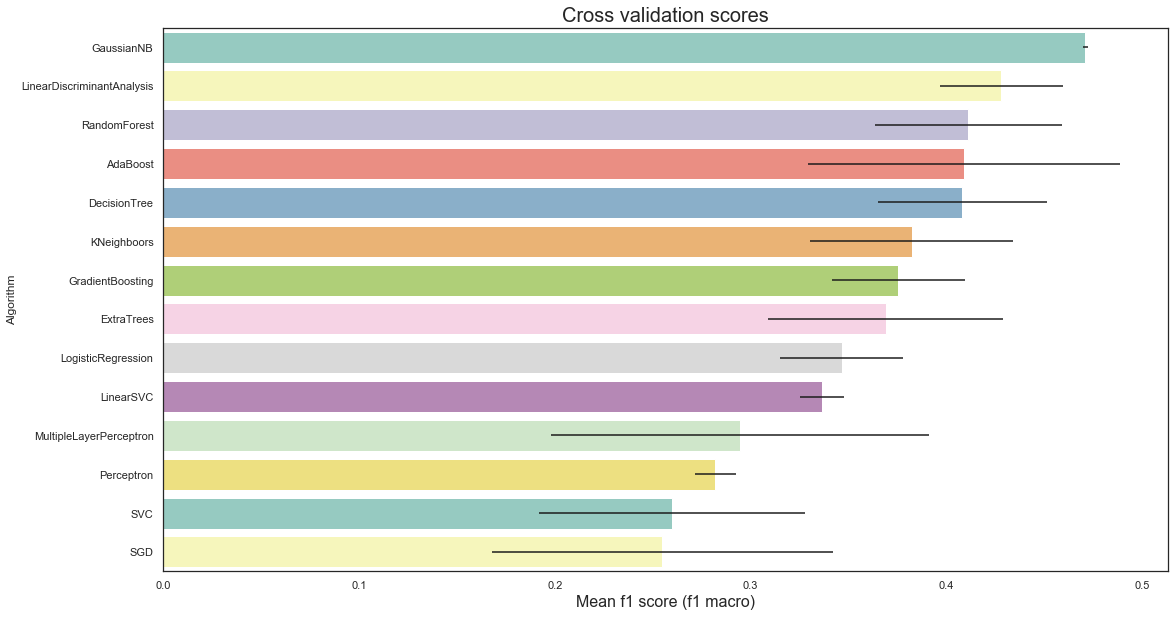

In [77]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation scores", size=20)

### Hyperparameter Tuning
Grid search to find an optimal hyperparameter. First define functions to perform training and show results.

In [99]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [107]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


### ADA Boost (on Decision Tree)

In [103]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

In [100]:
# Perform Random Hyperparamter Grid Search
rand_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" : [10, 50, 100, 200, 500],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]}

rand_model = RandomizedSearchCV(estimator=ada_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 364 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 614 tasks      | elapsed:   37.9s


0.4307310620711328
{'n_estimators': 10, 'learning_rate': 0.01, 'base_estimator__splitter': 'random', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME'}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   56.3s finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   17.2s finished
[2020-06-17 07:49:13,599][INFO] ## Training - acc: 0.98113208, f1: 0.97813528
[2020-06-17 07:49:13,602][INFO] ## Test - acc: 0.65000000, f1: 0.26262626


Best Score:  0.4154841622010546
Best Param:  {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 357}


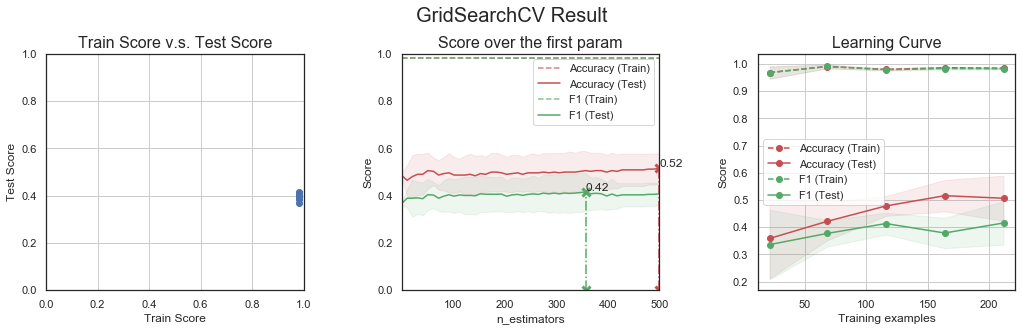

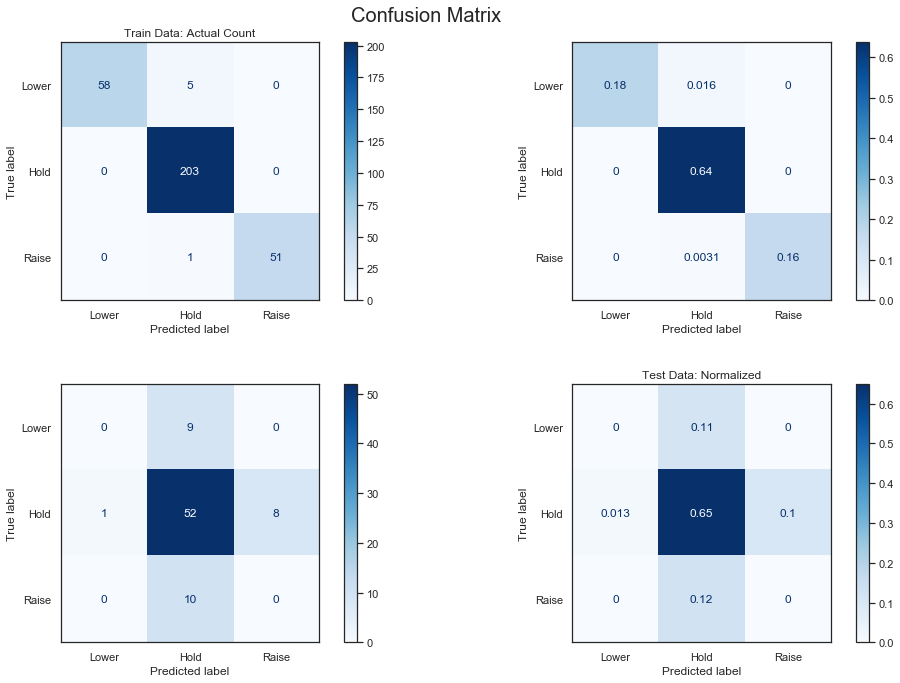

In [108]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME.R'],
              'learning_rate': [0.01]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

### Extra Tree

In [109]:
#ExtraTrees 
ext_clf = ExtraTreesClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 10, 20],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [False],
              "n_estimators" : [1, 2, 5, 10, 20, 100, 200, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=ext_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring='accuracy', verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/yuki/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.6446540880503144
{'n_estimators': 10, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   29.2s finished


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   15.7s finished
[2020-06-17 07:50:07,165][INFO] ## Training - acc: 0.63836478, f1: 0.25975688
[2020-06-17 07:50:07,168][INFO] ## Test - acc: 0.76250000, f1: 0.28841608


Best Score:  0.3902301039555942
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 1}


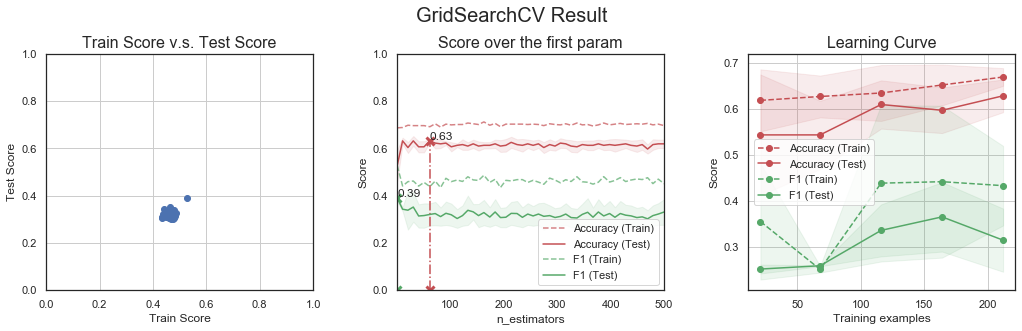

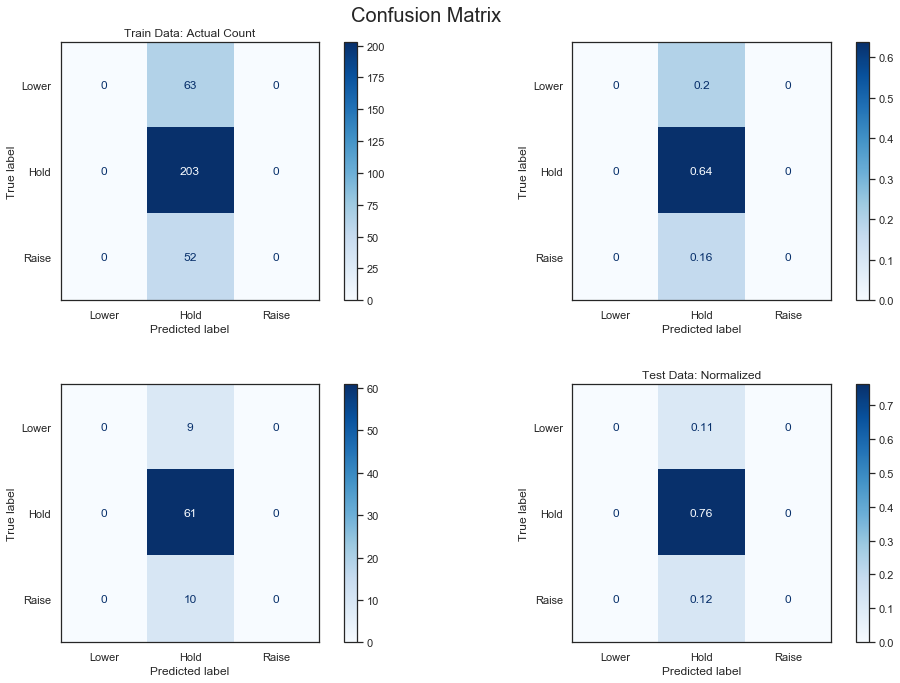

In [110]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [20],
              'min_samples_leaf': [7],
              'max_features': [1],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

### Random Forest

In [111]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10, 15],
              "bootstrap": [False],
              "n_estimators" :[1, 2, 5, 10, 100, 200, 300, 500, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=rf_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring='accuracy', verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   14.1s
/Users/yuki/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 781 tasks      | elapsed:   45.5s


0.6477987421383647
{'n_estimators': 10, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 2, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   53.1s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.9s finished
[2020-06-17 07:51:16,334][INFO] ## Training - acc: 0.69182390, f1: 0.56977347
[2020-06-17 07:51:16,337][INFO] ## Test - acc: 0.63750000, f1: 0.34055118


Best Score:  0.3881354606404995
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 15, 'min_samples_split': 7, 'n_estimators': 1}


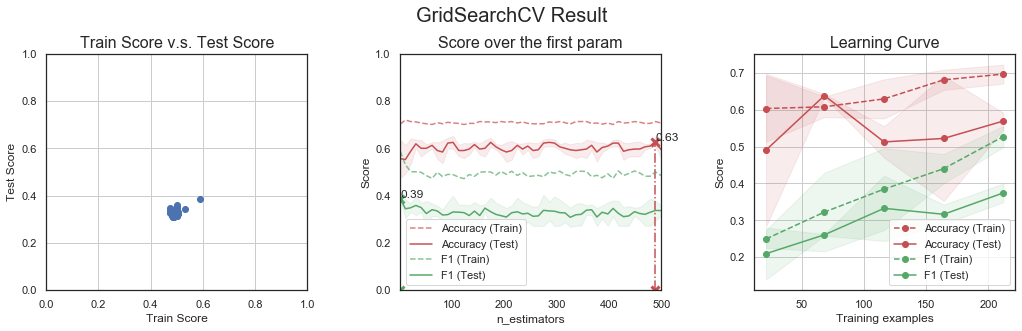

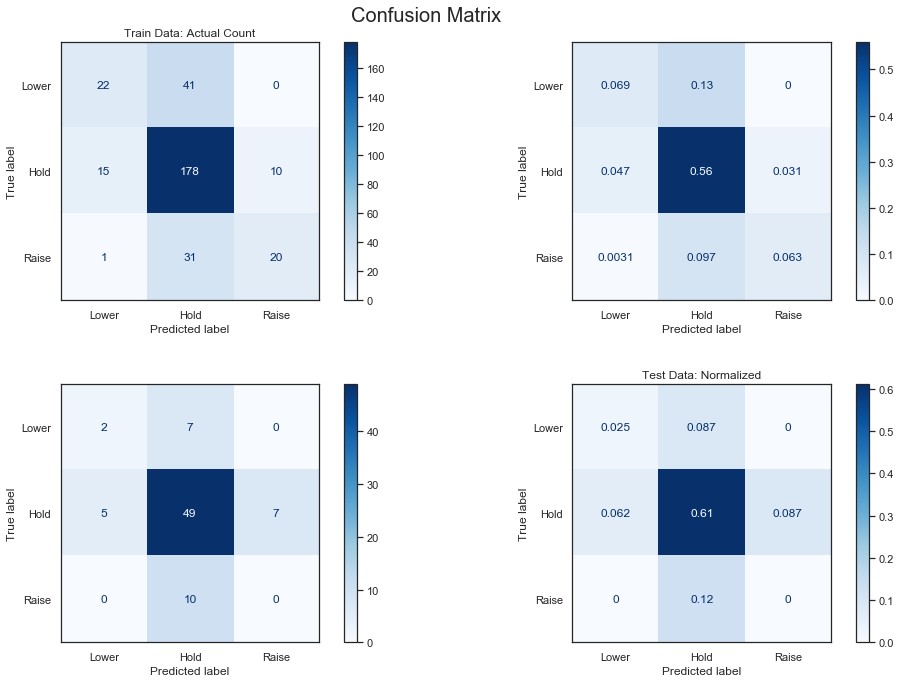

In [112]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [7],
              'min_samples_leaf': [15],
              'max_features': [1],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

### Gradient Boosting

In [113]:
# Gradient boosting
gb_clf = GradientBoostingClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [1, 10, 100, 200, 300, 1000],
              'learning_rate': [0.1, 0.05, 0.01, 0.005],
              'max_depth': [2, 4, 6, 8, 10],
              'min_samples_leaf': [10, 20, 50, 100, 150, 200, 300],
              'max_features': [0.3, 0.2, 0.1]
              }

rand_model = RandomizedSearchCV(estimator=gb_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring='accuracy', verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed:  1.4min


0.6477987421383647
{'n_estimators': 100, 'min_samples_leaf': 100, 'max_features': 0.1, 'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.1}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.6min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished
[2020-06-17 07:53:16,660][INFO] ## Training - acc: 0.69811321, f1: 0.53343653
[2020-06-17 07:53:16,662][INFO] ## Test - acc: 0.71250000, f1: 0.27737226


Best Score:  0.32841081905110053
Best Param:  {'learning_rate': 0.005, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 50, 'n_estimators': 469}


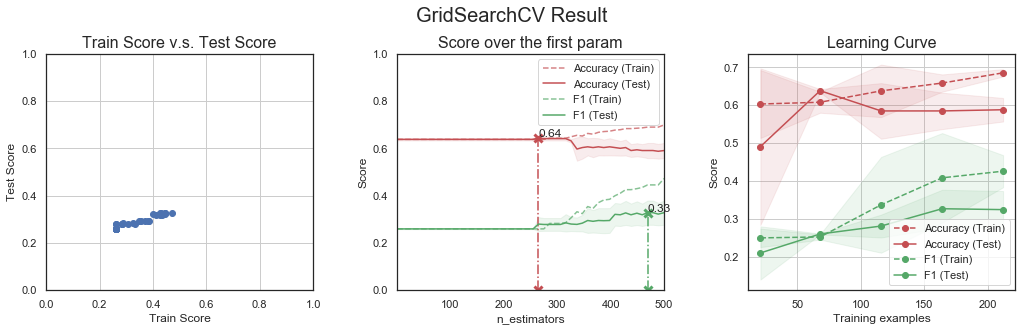

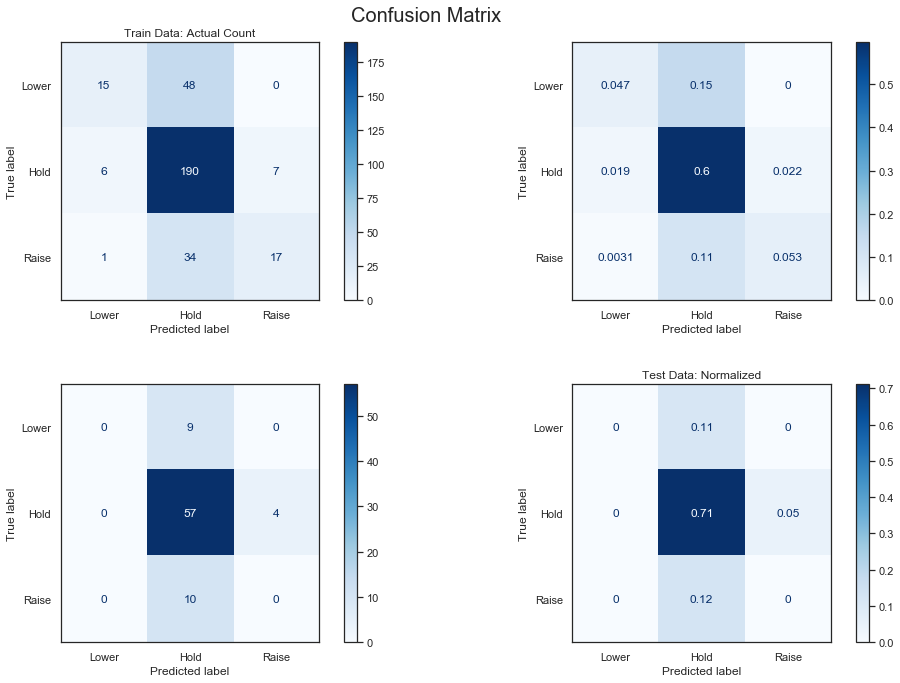

In [114]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_leaf': [50],
              'max_features': [0.3],
              'max_depth': [4],
              'loss': ['deviance'],
              'learning_rate': [0.005]}

gb_model = train_grid_search(gb_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
gb_best = gb_model.best_estimator_

### SVM

In [115]:
# Support Vector Machine
svm_clf = SVC(probability=True)

# Perform Random Hyperparamter Grid Search
rand_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                  'C': [1, 5, 10, 50, 100, 200, 300, 500, 1000]}

rand_model = RandomizedSearchCV(estimator=svm_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring='accuracy', verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)


/Users/yuki/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 63 is smaller than n_iter=300. Running 63 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 63 candidates, totalling 189 fits
0.6383647798742138
{'kernel': 'rbf', 'gamma': 0.01, 'C': 1}


[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:    0.8s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
[2020-06-17 07:53:26,078][INFO] ## Training - acc: 0.70440252, f1: 0.50277447
[2020-06-17 07:53:26,080][INFO] ## Test - acc: 0.70000000, f1: 0.27654321


Best Score:  0.39667722411940304
Best Param:  {'C': 1, 'gamma': 0.0021387755102040816, 'kernel': 'rbf'}


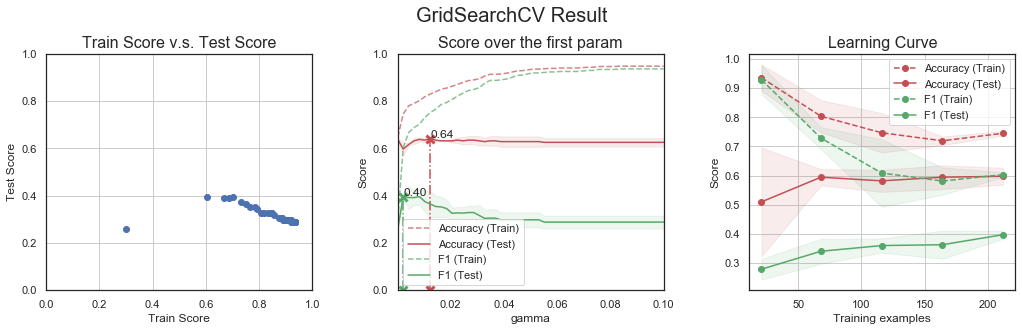

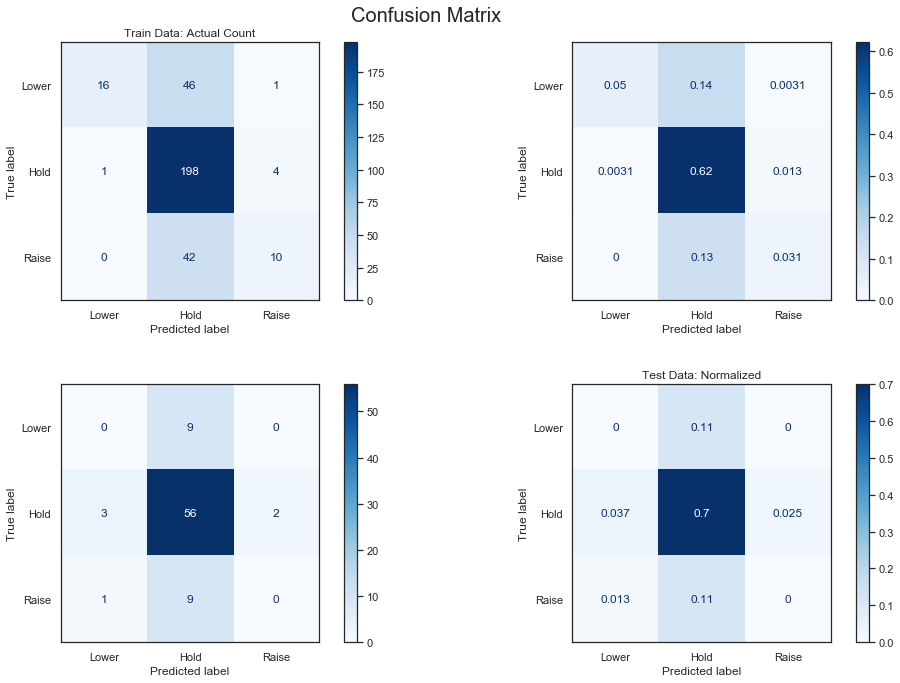

In [116]:
# Perform Grid Search
param_grid = {'gamma': np.linspace(0.0001, 0.1, 50, dtype=float),
              'C': [1],
              'kernel': ['rbf']}

svm_model = train_grid_search(svm_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
svm_best = svm_model.best_estimator_

### Feature Importance
Check feature importance on four tree-based classifiers out of ten.

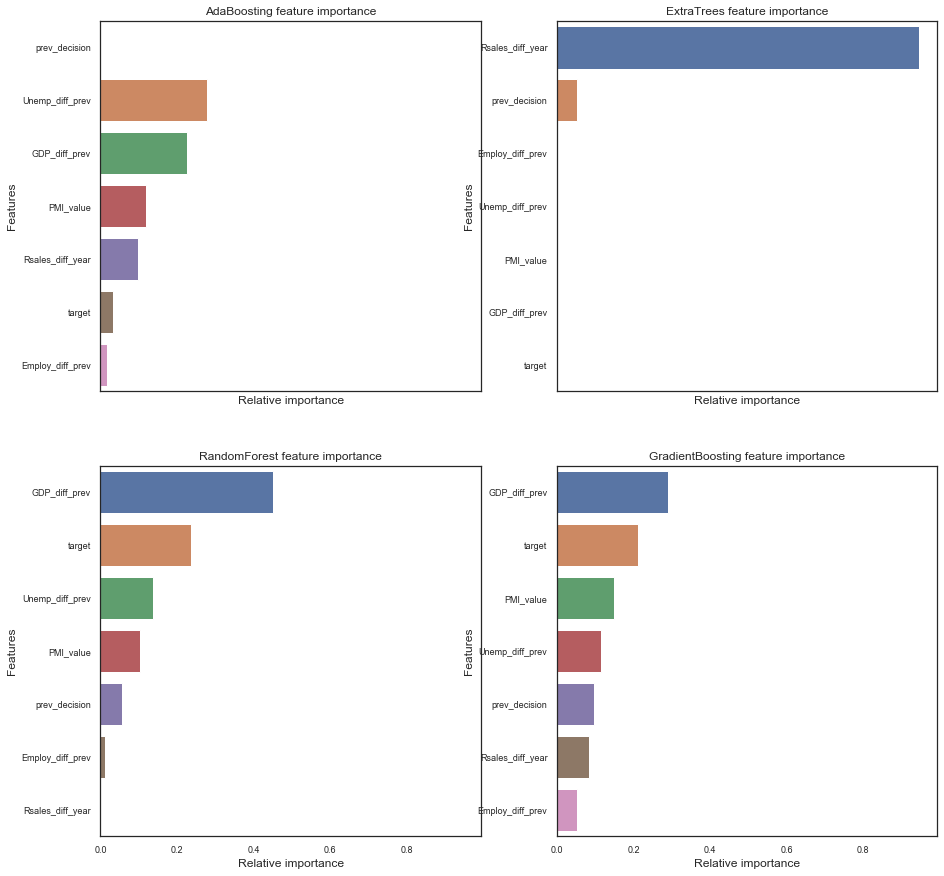

In [120]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=train_df.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

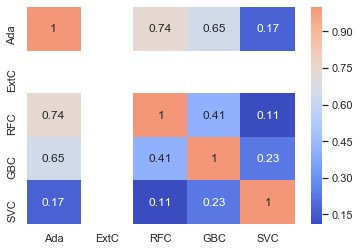

In [121]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")
test_svm = pd.Series(svm_best.predict(X_test), name="SVC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

/Users/yuki/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/yuki/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


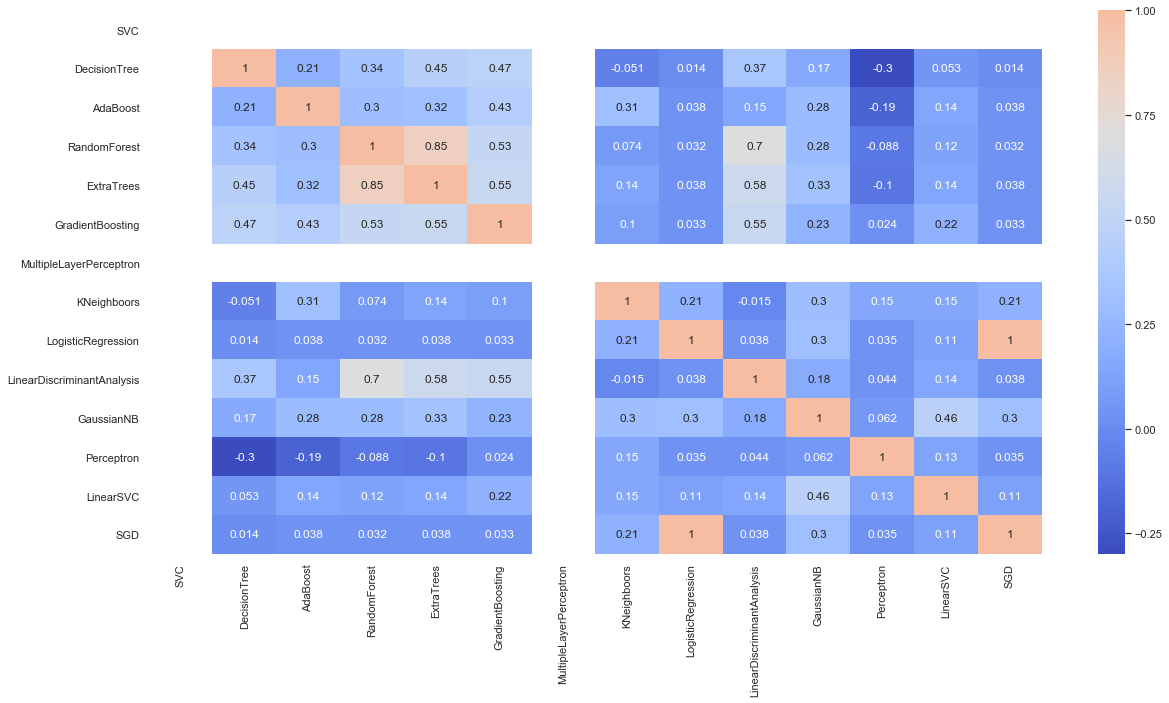

In [122]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

In [124]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best), 
                                           ('svmc', svm_best)], voting='soft', n_jobs=-1)

# # Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best = voting_best.fit(X_train, Y_train)

In [125]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-06-17 08:06:24,859][INFO] ## Training - acc: 0.82704403, f1: 0.75515337
[2020-06-17 08:06:24,861][INFO] ## Test - acc: 0.67500000, f1: 0.26865672


In [ ]:
# Save result
results = pd.concat([pd.Series(balanced.index.values), pd.Series(predict_voting, name="Predict")],axis=1)
results.to_csv("ensemble_best_voting.csv",index=False)

## B. Text data: Tfidf + logistic regression

In [ ]:

def build_tfidf_logreg(df, validation=True):
    x_train = df['text']
    y_train = df['target']
    clf = Pipeline([
                    ('tfidf', TfidfVectorizer(analyzer='word')),
                    ('clf', LogisticRegression())
    ])

    if validation:
        x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train.values, y_train.values, test_size=0.2, random_state=42)
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        predicted_valid = clf.predict(x_valid)

        acc, f1 = metric(y_train, predicted_train)
        logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
        acc, f1 = metric(y_valid, predicted_valid)
        logger.info('Validationn - acc: %.8f, f1: %.8f' % (acc, f1))

        # print("Training Accuracy: ", np.mean(predicted_train == y_train))
        # print("Validation Accuracy: ", np.mean(predicted_valid == y_valid))
    else:
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        acc, f1 = metric(y_train, predicted_train)
        logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[idx] for idx in y_valid]
    predicted_valid_class = [class_names[idx] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    return clf

model = build_tfidf_logreg(train_df)

## B) RNN/LSTM

Extract words which are only aphabet and not in stop word, covert to lower case.

In [ ]:
def tokenize_df(df):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        tokens = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
        tokenized.append(tokens)
    return tokenized

In [ ]:
tokenized = tokenize_df(text_no_split)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

In [ ]:
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

counts = Counter(all_words)
print('len(counts): ', len(counts))
print(counts[0:20])

bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

In [ ]:
# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

print("vocab['chairman']: ", vocab['chairman'])
print("vocab['market']: ", vocab['market'])

### Filter by frequency of words

This time, switch it off as the frequency is already considered while creating the vocabrary

In [ ]:
# freq = {}
# num_words = len(all_words)
# print('len(all_words): ', len(all_words))

# for key in counts:
#     freq[key] = counts[key]/num_words

# print('len(freq): ', len(freq))
# print(freq['rate'])

# low_cutoff = 0.000001
# high_cutoff = 20

# K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

# filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# print(K_most_common)
# print('len(filtered_words): ', len(filtered_words))

In [ ]:
# words_found, words_not_found = 0, 0
# token_ids = []
# for j, text in tqdm(enumerate(balanced['texts'])):
#     num_words = len(text) + 1
#     embedding_matrix = np.zeros((num_words, 300))
#     embedding_vector = []

#     for i, word in enumerate(text):
#         try:
#             embedding_vector.append(glove_dict.get(word))
#             words_found += 1
#         except KeyError:
#             embedding_vector.append(np.random.normal(scale=0.6, size=(300, )))
#             words_not_found += 1
#         print(embedding_vector)
#         embedding_matrix[i] = embedding_vector
#     token_ids.append(embedding_matrix)

# print(len(token_ids))
# print('Words Found: {}, Words Not Found: {}', words_found, words_not_found)
# token_ids = [[glove_dict.get(word) for word in text] for text in balanced['texts']]

text = tokenized[idx]

token_ids = [[vocab[word] for word in text] for text in balanced['texts']]
targets = balanced['targets']

print('token_ids: ', len(token_ids))
print('len(token_ids[0]): ', len(token_ids[0]))
print('token_ids[0]: ', token_ids[0])
print("------------------------")
print('targets: ', len(targets))
print('targets[0]: ', targets[0])
print('type(targets[0]): ', type(targets[0]))



### Model
#### Embed -> RNN -> Dense -> Softmax

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers,
                            dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input.size(0)
        nn_input = nn_input.long()
        embeds = self.embedding(nn_input)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs
        lstm_out = lstm_out[-1,:,:]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        logps = self.softmax(out)

        return logps, hidden_state


#### View Model

In [ ]:
# Embedding to 300 dimentions, 6 hidden dimentions, output 3 dimentions
model = TextClassifier(len(vocab), 300, 6, 3, dropout=0.1, lstm_layers=2)
print(model)

# Initialize the embedding weight with uniform distribution 
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5,4), dtype=torch.int64)
print('input: ', input)

hidden = model.init_hidden(4)
print('init hidden: ', hidden[0].shape, hidden[1].shape)
print(hidden)

logps, _ = model.forward(input, hidden)
print('logps after one step forward: \n', logps)
print('torch.exp(logps): \n', torch.exp(logps))

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [ ]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [ ]:
def dataloader(messages, labels, sequence_length=100, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Split Training and Validation

In [ ]:
# from sklearn import model_selection

# x_train, x_valid, y_train, y_valid = model_selection.train_test_split(text_pad, df['target'].values, test_size=0.2, random_state=42)
# print('Shape of train',x_train.shape)
# print("Shape of Validation ",x_valid.shape)
# word_index = tokenizer_obj.word_index
# print('Number of unique words: ', len(word_index))

In [ ]:
# Split data into training and validation datasets. Use an appropriate split size.

split_frac = 0.8

split_idx = int(len(token_ids)*split_frac)

train_features = token_ids[:split_idx]
valid_features = token_ids[split_idx:]
train_labels = targets[:split_idx]
valid_labels = targets[split_idx:]

print("len(token_ids): ", len(token_ids))
print("len(train_features): ", len(train_features))
print("len(valid_features): ", len(valid_features))
print("len(train_labels): ", len(train_labels))
print("len(valid_labels): ", len(valid_labels))

### Check the model and data

In [ ]:
text_batch, labels = next(iter(dataloader(train_features, train_labels)))
model = TextClassifier(len(vocab), 512, 128, 3, dropout=0.1)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

In [ ]:
# Define metrics
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

### Training


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = TextClassifier(len(vocab)+1, 300, 64, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

In [ ]:
epochs = 3
batch_size = 8
learning_rate = 1e-4
sequence_length = 200
clip=5

print_every = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    hidden = model.init_hidden(batch_size)
    steps = 0
    y_valid_epoch = []
    predicted_valid_epoch = []

    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
        steps += 1
        # Skip the last batch of which size is not equal to batch_size
        if text_batch.size(1) != batch_size:
            break

        # Creating new variables for the hidden state to avoid backprop entire training history
        hidden = tuple([each.data for each in hidden])
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # optimizer.zero_grad()
        model.zero_grad()
        
        # Get output and hidden state from the model
        output, hidden = model(text_batch, hidden)
        
        # Calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        
        # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Optimize
        optimizer.step()
        
        if steps % print_every == 0:
            model.eval()
            
            valid_losses = []
            accuracy = []
            predicted_valid = []
            y_valid = []
            valid_hidden = model.init_hidden(batch_size)
            
            for text_batch, labels in dataloader(
                    valid_features, valid_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
                
                # Skip the last batch of which size is not equal to batch_size
                if text_batch.size(1) != batch_size:
                    break

                # Initialize within the loop to use label shape because batch_size did not work
                # valid_hidden = model.init_hidden(labels.shape[0])
 
                # Creating new variables for the hidden state
                valid_hidden = tuple([each.data for each in valid_hidden])
                
                # Set Device
                text_batch, labels = text_batch.to(device), labels.to(device)
                for each in valid_hidden:
                    each.to(device)
                
                # Get output and hidden state from the model
                valid_output, valid_hidden = model(text_batch, valid_hidden)
                
                # Calculate the loss
                valid_loss = criterion(valid_output.squeeze(), labels)
                valid_losses.append(valid_loss.item())
                
                # Accuracy
                ps = torch.exp(valid_output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                predicted_valid.extend(top_class.squeeze().cpu().numpy())
                y_valid.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())
                
            model.train()
            acc, f1 = metric(y_valid, predicted_valid)
            predicted_valid_epoch.extend(predicted_valid)
            y_valid_epoch.extend(y_valid)

            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(steps),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                  "Accuracy: {:.6f}".format(acc),
                  "F1 Score: {:.6f}".format(f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    acc, f1 = metric(y_valid_class, predicted_valid_class)
    print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
    plt.show()


## C) GloVe Word Embedding + LSTM

Download GloVe embeddings. Only for the first time.

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

# embedding_dict = {}

# with open("glove.6B.300d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], 'float32')
#         embedding_dict[word] = vectors
# f.close()

# pickle.dump(embedding_dict, open('drive/My Drive/Colab Data/glove.6B.300d.pickle', 'wb'))

# embedding_dict = {}

# with open("glove.6B.100d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], 'float32')
#         embedding_dict[word] = vectors
# f.close()

# pickle.dump(embedding_dict, open('drive/My Drive/Colab Data/glove.6B.100d.pickle', 'wb'))

In [ ]:
glove_dict = pickle.load(open('drive/My Drive/Colab Data/glove.6B.300d.pickle', 'rb'))
print(len(glove_dict))
glove_dict['the']

In [ ]:
type(glove_dict)

In [ ]:
weight_matrix = np.zeros((len(vocab), 300))
weight_matrix.shape
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('words_found: ', words_found)

# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
# from keras.initializers import Constant
# from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam

# model = Sequential()

# embedding = Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)
# model.add(embedding)
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# optimizer = Adam(lr=1e-5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

# history = model.fit(x_train, y_train, batch_size=4, epochs=10, validation_data=(x_valid, y_valid), verbose=2)


In [ ]:
weight_matrix.shape

In [ ]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers,
                            dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input.size(0)
        nn_input = nn_input.long()
        embeds = self.embedding(nn_input)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs
        lstm_out = lstm_out[-1,:,:]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        logps = self.softmax(out)

        return logps, hidden_state



### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 64, 3, lstm_layers=2, dropout=0.2)
model.to(device)

In [ ]:
epochs = 3
batch_size = 8
learning_rate = 1e-4
sequence_length = 200
clip=5

print_every = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    hidden = model.init_hidden(batch_size)
    steps = 0
    y_valid_epoch = []
    predicted_valid_epoch = []

    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
        steps += 1
        # Skip the last batch of which size is not equal to batch_size
        if text_batch.size(1) != batch_size:
            break

        # Creating new variables for the hidden state to avoid backprop entire training history
        hidden = tuple([each.data for each in hidden])
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # optimizer.zero_grad()
        model.zero_grad()
        
        # Get output and hidden state from the model
        output, hidden = model(text_batch, hidden)
        
        # Calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        
        # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Optimize
        optimizer.step()
        
        if steps % print_every == 0:
            model.eval()
            
            valid_losses = []
            accuracy = []
            predicted_valid = []
            y_valid = []
            valid_hidden = model.init_hidden(batch_size)
            
            for text_batch, labels in dataloader(
                    valid_features, valid_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
                
                # Skip the last batch of which size is not equal to batch_size
                if text_batch.size(1) != batch_size:
                    break

                # Initialize within the loop to use label shape because batch_size did not work
                # valid_hidden = model.init_hidden(labels.shape[0])
 
                # Creating new variables for the hidden state
                valid_hidden = tuple([each.data for each in valid_hidden])
                
                # Set Device
                text_batch, labels = text_batch.to(device), labels.to(device)
                for each in valid_hidden:
                    each.to(device)
                
                # Get output and hidden state from the model
                valid_output, valid_hidden = model(text_batch, valid_hidden)
                
                # Calculate the loss
                valid_loss = criterion(valid_output.squeeze(), labels)
                valid_losses.append(valid_loss.item())
                
                # Accuracy
                ps = torch.exp(valid_output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                predicted_valid.extend(top_class.squeeze().cpu().numpy())
                y_valid.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())
                
            model.train()
            acc, f1 = metric(y_valid, predicted_valid)
            predicted_valid_epoch.extend(predicted_valid)
            y_valid_epoch.extend(y_valid)

            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(steps),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                  "Accuracy: {:.6f}".format(acc),
                  "F1 Score: {:.6f}".format(f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    acc, f1 = metric(y_valid_class, predicted_valid_class)
    print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
    plt.show()


In [ ]:
# # Save results to Drive
# file = open('drive/My Drive/Colab Data/statement_trained_df.pickle', 'wb')
# pickle.dump(train_df, file)
# file.close()

# train_df.to_csv('drive/My Drive/Colab Data/statement_trained_df.csv', index=False)